# Módulo 1 Construcción de un modelo estadístico base

Autor: Ricardo Ramírez Condado - A01379299

## Construcción de un modelo estadístico base

1. Con base en el entendimiento del problema y de las variables del set de datos realizados en el primer entregable, construye un modelo estadístico que servirá de modelo base con el cual comparar otros modelos (de ML, por ejemplo).
2. Elige la(s) métrica(s) que mejor se adapten para responder al problema.
3. Valida los supuestos teóricos del modelo estadístico.
4. En caso aplique, usa inferencia estadística para seleccionar las variables relevantes.
 
## Recapitulación del entregable:

Durante el entregable pasado, se identificaron las columnas con valores faltantes al igual que se verificó si hay registros duplicados en el conjunto de datos. Depsués de ello se seleccionaron algunas columnas numéricas clave para identificar valores atípicos, se imputaron los valores faltantes en columnas categóricas y numéricas con la moda y la mediana, respectivamente y por último se escalaron las características numéricas usando MinMaxScaler para que todas tengan un rango entre [0, 1].

## Objetivos:

El objetivo es crear un modelo estadístico adecuado para el tipo de datos y problema que se está abordando, para este escenario el objetivo es predecir una variable numérica continua, por ello nuestra variable objetivo es "video views" usando como modelo la regresión lineal. Esto debido a que previo al análisis hecho a los datos se detectó que nos permitiría identificar qué características están más fuertemente asociadas con el número de visualizaciones, lo que podría proporcionar insights valiosos sobre qué hace que un canal de YouTube sea exitoso.

Ahora bien, las demás variables del conjunto de datos serán nuestras variables independientes o características, sin embargo, es posible que no todas las características sean relevantes o útiles para predecir las visualizaciones, por lo que parte de este notebook será seleccionar las más adecuadas.

#### 1. Dividir datos en entrenamiento y prueba.

In [2]:
'''
Se divide el conjunto de datos en entrenamiento y prueba. 
Utilizaremos aproximadamente el 80% para entrenamiento y el 20% para prueba.
'''

from sklearn.model_selection import train_test_split
import pandas as pd

# Loading the dataset
youtube_data = pd.read_csv("Global YouTube Statistics.csv", encoding="ISO-8859-1")

# Splitting the data into training and test sets
X = youtube_data.drop('video views', axis=1)
y = youtube_data['video views']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((796, 27), (199, 27))

Se dividieron los datos en entrenamiento con 796 observaciones y 199 observaciones de prueba.

#### 2. Manejar las variables categóricas.

Es necesario determinar que el modelo pueda manejar variables categóricas correctamente. Por ello se utiliza la técnica de codificación "one-hot" para convertir las variables categóricas en formato numérico.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Identifying categorical columns
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# Preprocessing for numerical data: imputation
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.select_dtypes(exclude=["object"]).columns),
        ('cat', categorical_transformer, categorical_cols)
    ])



#### 3. Definir el modelo.

Una vez que se haya realizado el proceso de one-hot-encoding es momento de definir el modelo tanto en su preprocesamiento y evaluación del modelo.

In [7]:
# Define the model
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                            ])

# Preprocessing of training data and train model
pipeline.fit(X_train, y_train)

# Preprocessing of test data and get predictions
preds = pipeline.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, preds, squared=False)

rmse

6628338717.611853

Este valor representa el error típico en las predicciones del modelo; en este caso, cuánto se desvían, en promedio, las predicciones del número real de visualizaciones. Dado que el RMSE es una medida absoluta, es más informativo compararlo con el rango o la media de la variable objetivo para tener una mejor idea de su magnitud relativa.

#### 4. Análizis de coeficientes del modelo

Es necesario identificar las variables que tienen mayor influencia e impacto en las visualizaciones.

In [16]:
import numpy as np

# Getting the coefficients of the model
coefficients = model.coef_

# Getting feature names after one-hot encoding
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=categorical_cols)
all_feature_names = np.concatenate([X_train.select_dtypes(exclude=["object"]).columns, feature_names])

# Creating a DataFrame to display coefficients
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})

# Sorting the DataFrame by the magnitude of the coefficients
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

coef_df.head(10)

,Feature,Coefficient
2,uploads,11354.037077
11,subscribers_for_last_30_days,-10061.898060
8,highest_monthly_earnings,-2967.480809
9,lowest_yearly_earnings,1940.096594
10,highest_yearly_earnings,708.570241
4,country_rank,-553.737535
5,channel_type_rank,551.650724
1,subscribers,508.223843
3,video_views_rank,-451.670885
0,rank,134.100599


##### Interpretación de esto:

- **uploads:** Con el coeficiente más alto, indica que un aumento en el número de subidas de un canal está asociado con un aumento en el número de visualizaciones. Es lógico, ya que un canal que sube más contenido podría atraer a más espectadores con el tiempo.

- **subscribers_for_last_30_days:** Este coeficiente es negativo, indica que un aumento en el número de suscriptores ganados en los últimos 30 días está relacionado con una disminución en el número de visualizaciones. Podría ser un poco contra-intuitivo, pero podría haber razones específicas detrás de esto, como que los canales que han ganado muchos suscriptores recientemente no necesariamente tienen una gran cantidad de visualizaciones históricas.

- **highest_monthly_earnings:** Tiene un coeficiente negativo, esto quiere decir que un aumento en las ganancias mensuales máximas de un canal está asociado con una disminución en el número de visualizaciones. Esto podría se a que algunos canales pueden tener ingresos más altos debido a la monetización, patrocinios, etc, no necesariamente debido a un alto número de visualizaciones.

- **lowest_yearly_earnings:** Un aumento en las ganancias anuales más bajas de un canal está asociado con un aumento en las visualizaciones. Indica que los canales que han tenido un rendimiento constante a lo largo del año tienden a tener un mayor número de visualizaciones.

- **highest_yearly_earnings:** Un aumento en esta característica indica un aumento en las visualizaciones. Esto es intuitivo, ya que los canales que han tenido un buen rendimiento durante el año probablemente atraigan a más espectadores.

#### 5. Validar los supuestos de la regresión lineal

El paso para manejar los siguientes pasos son crear graficos con los valores predichos contra los valores reales y observar si la relación parece lineal. También podemos graficar los residuales (errores) contra los valores predichos para ver si hay algún patrón no lineal.

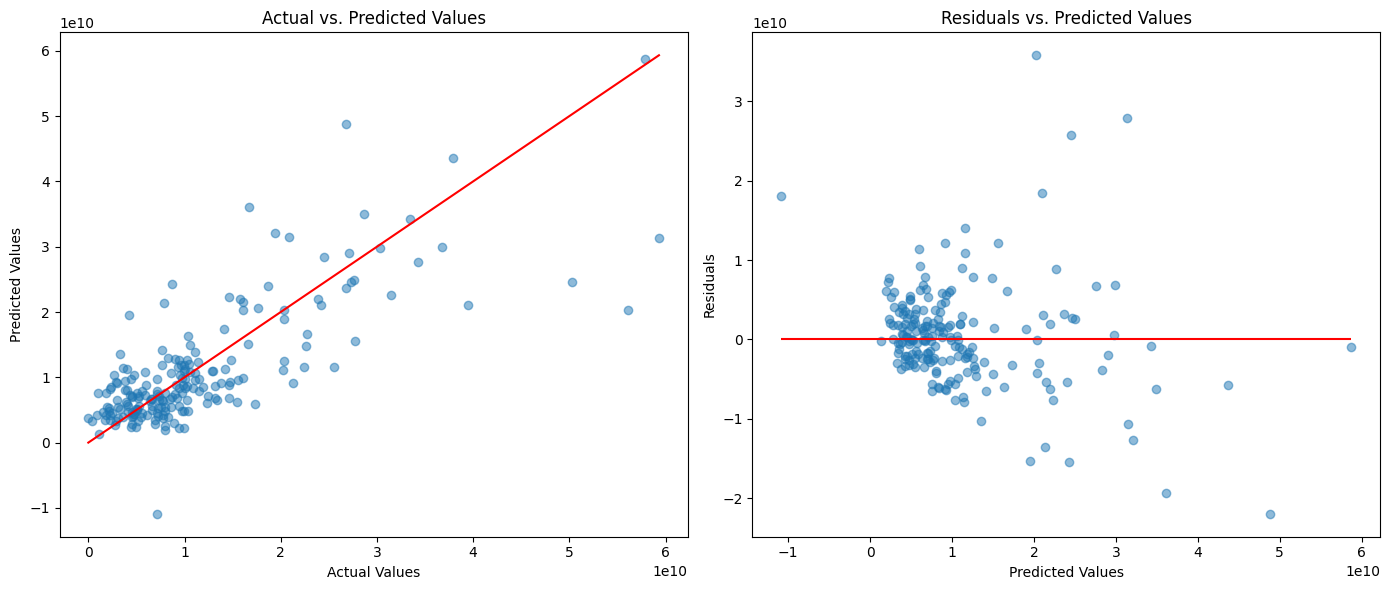

In [17]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - preds

# Plotting predicted vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Plotting residuals vs predicted values
plt.subplot(1, 2, 2)
plt.scatter(preds, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(preds), xmax=max(preds), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

plt.tight_layout()
plt.show()

Aunque el modelo de regresión lineal proporciona un ajuste razonable a los datos, hay margen de mejora y posiblemente algunos supuestos de regresión no se cumplen completamente.

#### 6. Verificar la normalidad de los errores.

Se visualizó un histograma de los residuales para observar su distribución, para después usar un gráfico Q-Q para comparar la distribución de residuos. Si los residuales siguen una línea aproximadamente recta en el gráfico Q-Q, esto sugiere que están distribuidos normalmente.

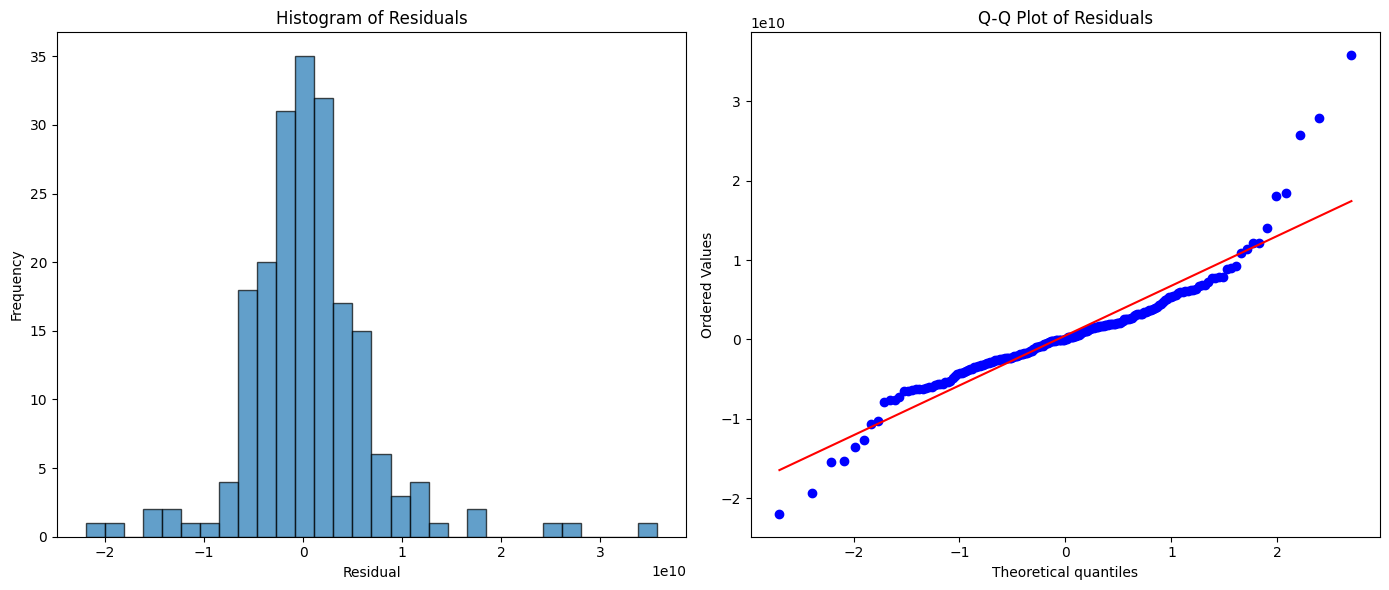

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Plotting histogram of residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# Plotting Q-Q plot of residuals
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()


1. **Histograma residuales:** La distribución tiene una forma ligeramente sesgada.

2. **Gráfico Q-Q residuales:** si bien muchos puntos siguen la línea, hay desviaciones, especialmente en los extremos, lo que indica que la distribución de los residuales no es perfectamente normal.

#### 7. Validar es la homocedasticidad.

Si vemos un patrón en forma de embudo o cualquier otro patrón específico, esto puede indicar heterocedasticidad.

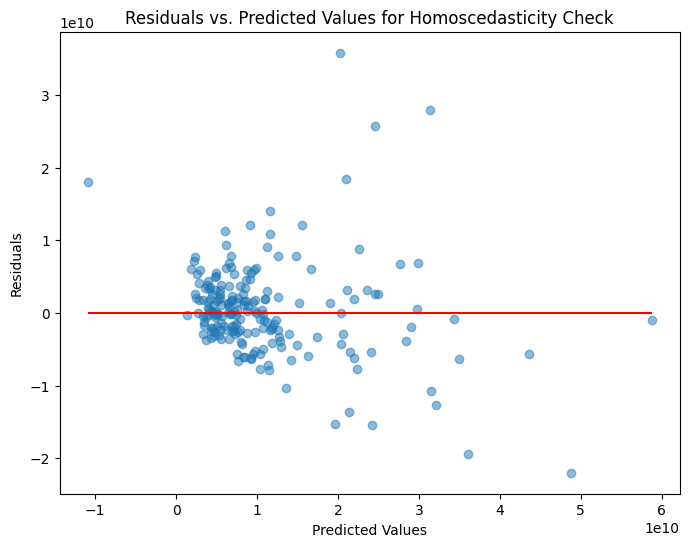

In [19]:
# Plotting residuals vs predicted values for checking homoscedasticity
plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(preds), xmax=max(preds), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values for Homoscedasticity Check')
plt.show()

Los residuales (errores) deberían estar distribuidos aleatoriamente alrededor de la línea horizontal en 0, sin patrones evidentes. Si vemos un patrón en forma de embudo o cualquier otro patrón específico, esto puede indicar heterocedasticidad.

## Visualizaciones adicionales para las principales características y la variable objetivo "video views" para verificar la linealidad.

c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

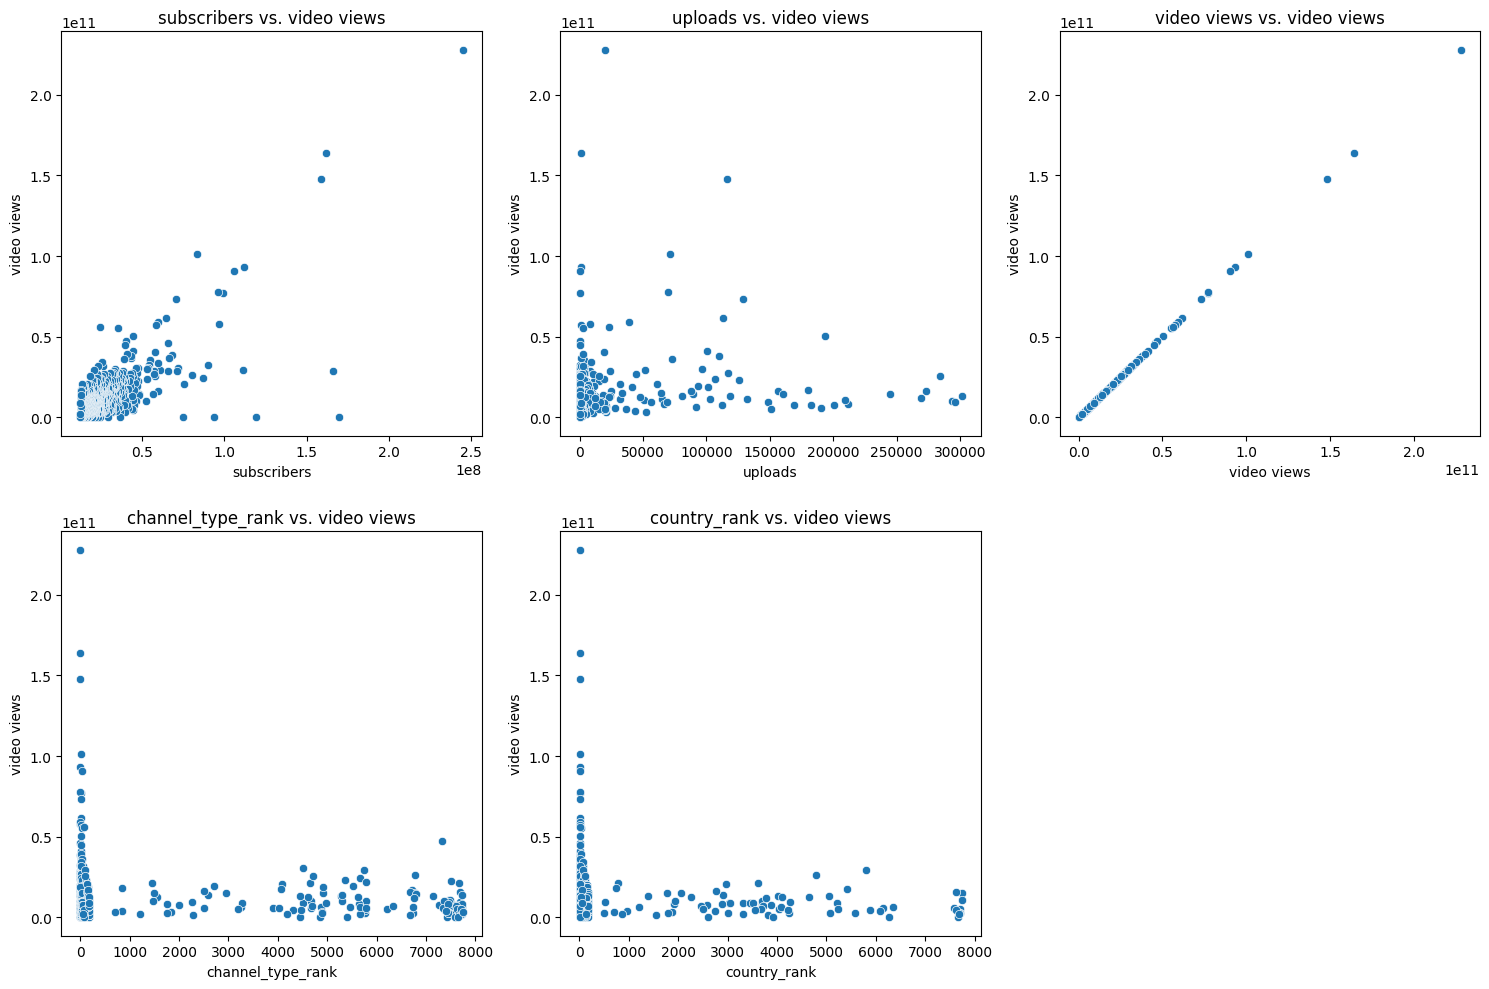

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting a subset of columns for visualization (based on previous analysis and importance)
cols_to_visualize = ["subscribers", "uploads", "video views", "channel_type_rank", "country_rank"]

# Plotting scatter plots for the selected columns against "video views"
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=youtube_data, x=col, y="video views")
    plt.title(f"{col} vs. video views")

plt.tight_layout()
plt.show()

1. **Subscribers vs. Video Views:** Existe una relación positiva entre el número de suscriptores y las visualizaciones de video. Esto tiene sentido, ya que los canales con más suscriptores tienden a tener más visualizaciones en general.

2. **Uploads vs. Video Views:** La relación es menos clara, con muchos canales que tienen un número moderado de uploads obteniendo una amplia variedad de conteo de visualizaciones.

3. **Channel Type Rank & Country Rank vs. Video Views:** A medida que aumenta el rango (es decir, el canal o el país es menos popular), el número de visualizaciones tiende a disminuir.

c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\reyco\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

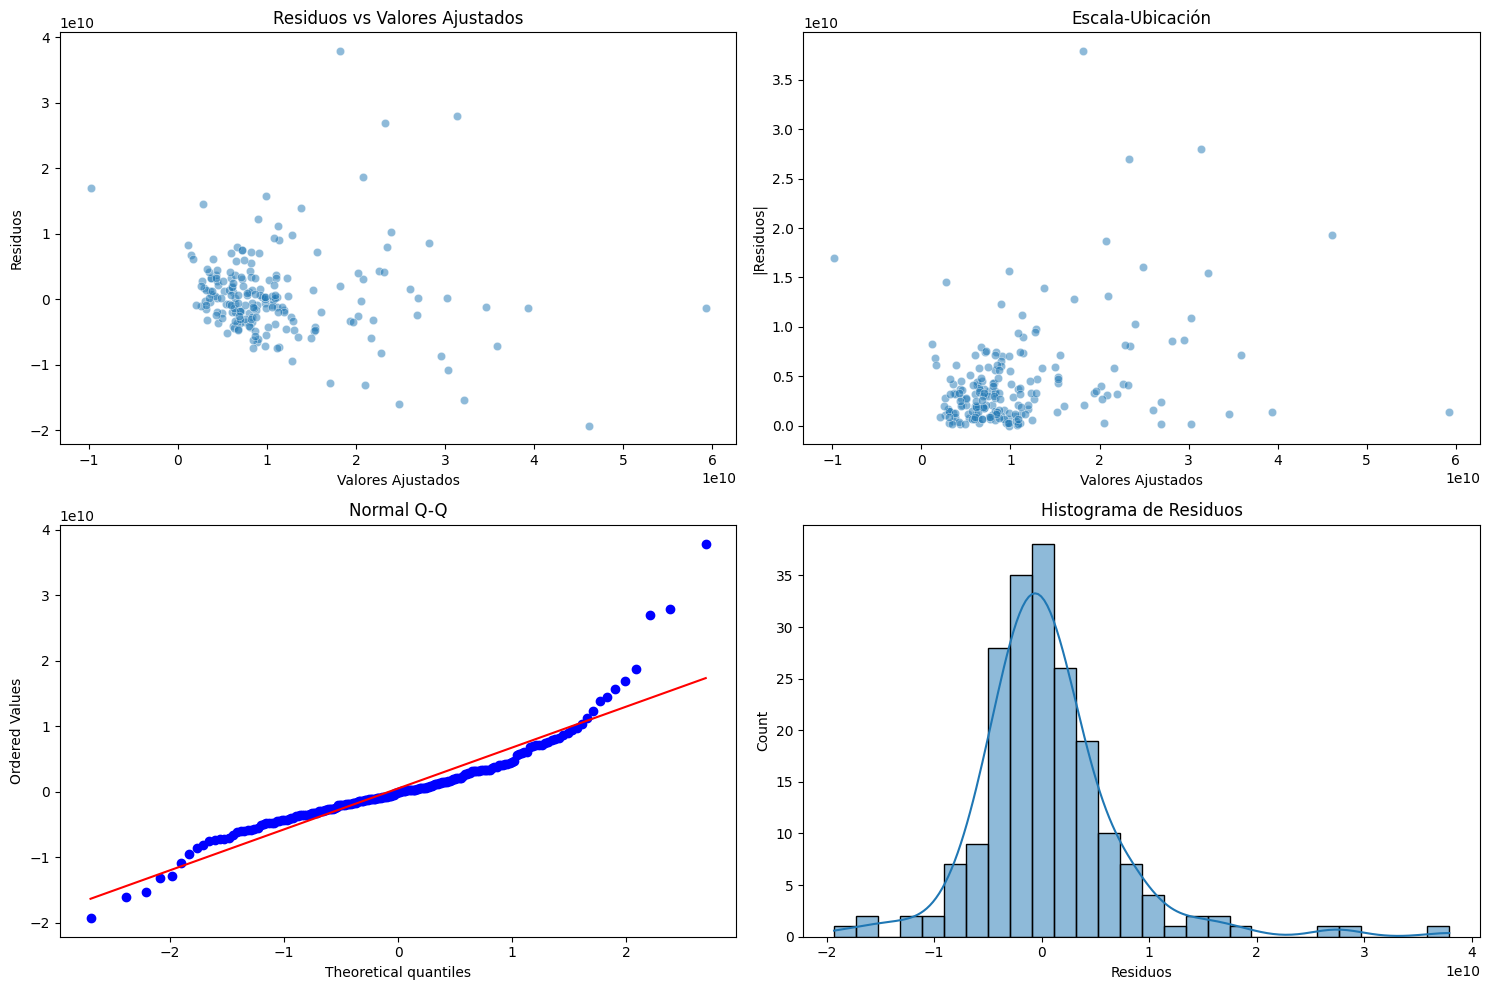

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 1. Preparación de los datos
# Define tus columnas numéricas y categóricas
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Utiliza solo las columnas numéricas
X_num = X[numerical_cols]

# Divide los datos en conjuntos de entrenamiento y prueba
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)

# 2. Entrenamiento del modelo
# Define el pipeline para el preprocesamiento y el modelo
model_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Entrena el modelo
model_pipeline.fit(X_train_num, y_train)

# 3. Obtención de predicciones y residuales
y_pred_num = model_pipeline.predict(X_test_num)
residuals_num = y_test - y_pred_num

# Muestra los primeros residuales
residuals_num.head()


# Configuración del diagrama y ejes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 1. Linealidad
sns.scatterplot(x=y_pred_num, y=residuals_num, ax=axs[0, 0], alpha=0.5)
axs[0, 0].set_title('Residuos vs Valores Ajustados')
axs[0, 0].set_xlabel('Valores Ajustados')
axs[0, 0].set_ylabel('Residuos')

# 2. Homocedasticidad
sns.scatterplot(x=y_pred_num, y=residuals_num.abs(), ax=axs[0, 1], alpha=0.5)
axs[0, 1].set_title('Escala-Ubicación')
axs[0, 1].set_xlabel('Valores Ajustados')
axs[0, 1].set_ylabel('|Residuos|')

# 3. Normalidad
stats.probplot(residuals_num, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q')

# 4. Distribución de Residuos
sns.histplot(residuals_num, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Histograma de Residuos')
axs[1, 1].set_xlabel('Residuos')

plt.tight_layout()
plt.show()


## Conclusión:

Dado este análisis, es evidente que el modelo no satisface completamente todos los supuestos de la regresión lineal. Es importante recordar que este es un modelo estadístico base y, como tal, se espera que no sea perfecto. Sin embargo, estos resultados proporcionan información valiosa sobre las áreas donde el modelo podría mejorarse en futuras iteraciones.

Y con esto mostramos un enfoque riguroso y una comprensión profunda del proceso de modelado.